<a href="https://colab.research.google.com/github/cutemfc/Time_series_project/blob/main/Project_Exponential_Smoothing_model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, r2_score
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import warnings
warnings.simplefilter('ignore')

In [ ]:
# mount google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Step1: Load data and data preporcessing

In [ ]:
# Load the data
# read file to analysis
df_filled=pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/df_filled.csv')

In [ ]:
df_train=df_filled.copy()
df_train.head()

,store_nbr,item_nbr,date,id,unit_sales,onpromotion
0,24,105574,2013-01-02,18790.0,12.0,0.0
1,24,105574,2013-01-03,59692.0,1.0,0.0
2,24,105574,2013-01-04,99664.0,3.0,0.0
3,24,105574,2013-01-05,140805.0,4.0,0.0
4,24,105574,2013-01-06,182800.0,7.0,0.0


In [ ]:
# Filter the data before 2014-04-01
max_date = '2014-04-01'
df_train = df_train[df_train['date'] < max_date]
df_train.head()
df_train.shape

(9437752, 6)

In [ ]:
## Groupby by 'date' and aggregate 'unit_sales' by sum
df_train = df_train.groupby('date')['unit_sales'].sum().reset_index()

In [ ]:
df_train.head()

,date,unit_sales
0,2013-01-02,42320.0
1,2013-01-03,32708.0
2,2013-01-04,30849.0
3,2013-01-05,42351.0
4,2013-01-06,43988.0


In [ ]:

# Time based Features
# Convert date Column to datetime
df_train['date']=pd.to_datetime(df_train['date'])
# Creating new time-based deatures
df_train['year']=df_train['date'].dt.year
df_train['month']=df_train['date'].dt.month
df_train['day']=df_train['date'].dt.day
df_train['day_of_week']=df_train['date'].dt.dayofweek


In [ ]:
df_train.head()

,date,unit_sales,year,month,day,day_of_week
0,2013-01-02,42320.0,2013,1,2,2
1,2013-01-03,32708.0,2013,1,3,3
2,2013-01-04,30849.0,2013,1,4,4
3,2013-01-05,42351.0,2013,1,5,5
4,2013-01-06,43988.0,2013,1,6,6


#step 2: Spilt data

In [ ]:
# Train-test split:
from sklearn.model_selection import train_test_split


train, test = train_test_split(df_train, test_size=0.2, shuffle=False)# time series need to keep the order

In [ ]:
train.head()

,date,unit_sales,year,month,day,day_of_week
0,2013-01-02,42320.0,2013,1,2,2
1,2013-01-03,32708.0,2013,1,3,3
2,2013-01-04,30849.0,2013,1,4,4
3,2013-01-05,42351.0,2013,1,5,5
4,2013-01-06,43988.0,2013,1,6,6


In [ ]:
test.head()

,date,unit_sales,year,month,day,day_of_week
363,2013-12-31,58694.000,2013,12,31,1
364,2014-01-01,2005.868,2014,1,1,2
365,2014-01-02,61947.875,2014,1,2,3
366,2014-01-03,54187.897,2014,1,3,4
367,2014-01-04,71364.655,2014,1,4,5


In [ ]:
print(train.isnull().sum())
print(test.isnull().sum())

date           0
unit_sales     0
year           0
month          0
day            0
day_of_week    0
dtype: int64
date           0
unit_sales     0
year           0
month          0
day            0
day_of_week    0
dtype: int64


#Step 3: Naive Model, Simple average Model and triple exponential smoothing(Holt-Winters) Building

In [ ]:
# naive Forcasting(predict the last day.iloc[-1])
navie_forecast = pd.Series(index=test.index, data=[train.iloc[-1]['unit_sales']] * len(test))

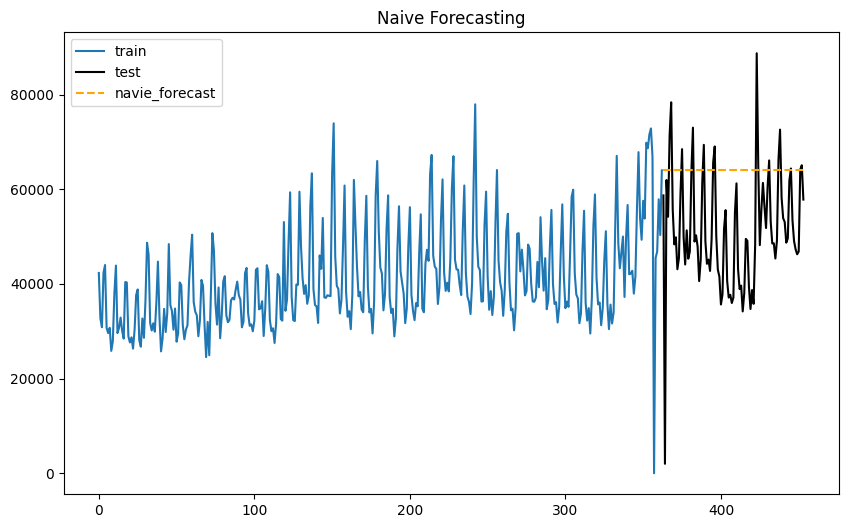

In [ ]:
# plot the actual test data and naive_forcast data
plt.figure(figsize=(10, 6))
plt.plot(train['unit_sales'],label='train')
plt.plot(test['unit_sales'],label='test',color='black')
plt.plot(navie_forecast,label='navie_forecast',linestyle='--', color='orange')
plt.legend()
plt.title('Naive Forecasting')
plt.show()

In [ ]:
print("Train index range:", train.index.min(), "to", train.index.max())
print("Test index range:", test.index.min(), "to", test.index.max())

Train index range: 0 to 362
Test index range: 363 to 453


In [ ]:
train['unit_sales'].describe()

,unit_sales
count,363.000000
mean,40984.694215
std,10383.644176
min,0.000000
25%,33977.000000
50%,38144.000000
75%,46112.500000
max,77934.000000


In [ ]:
test['unit_sales'].describe()

,unit_sales
count,91.000000
mean,51277.441308
std,12095.698516
min,2005.868000
25%,44172.471500
50%,49423.884000
75%,58933.351000
max,88715.769000


In [ ]:
# simple average forecasting
simple_avg_forecast=pd.Series(index=test.index, data=train['unit_sales'].mean())

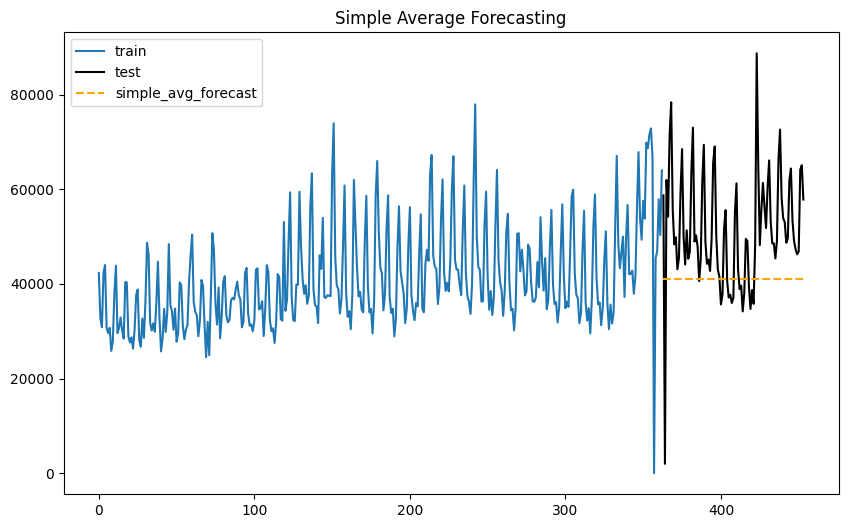

In [ ]:
# plot the actual test data and naive_forcast data
plt.figure(figsize=(10, 6))
plt.plot(train['unit_sales'],label='train')
plt.plot(test['unit_sales'],label='test',color='black')
plt.plot(simple_avg_forecast,label='simple_avg_forecast',linestyle='--', color='orange')
plt.legend()
plt.title('Simple Average Forecasting')
plt.show()

In [ ]:
# triple exponential smoothing(Holt-Winters)
holt_winters_model=ExponentialSmoothing(train['unit_sales'], seasonal='add',seasonal_periods=7,trend='add').fit()

In [ ]:
# forecast the holt-winters
hw_forecast=holt_winters_model.forecast(len(test))


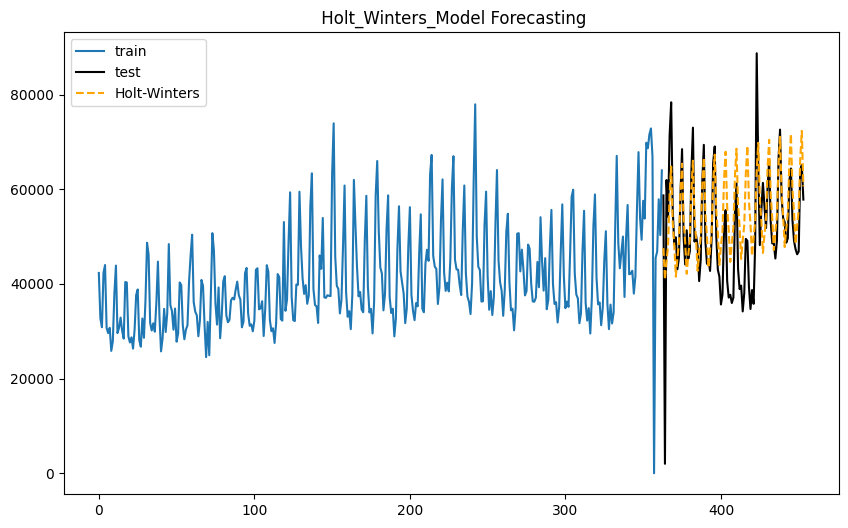

In [ ]:
# plot the actual test data and naive_forcast data
plt.figure(figsize=(10, 6))
plt.plot(train['unit_sales'],label='train')
plt.plot(test['unit_sales'],label='test',color='black')
plt.plot(hw_forecast,label='Holt-Winters',linestyle='--', color='orange')
plt.legend()
plt.title(' Holt_Winters_Model Forecasting')
plt.show()

# Step 4: Model Evaluation

In [ ]:
# Evaluation the model by R2, MSE, and MPSE
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import r2_score
mse=mean_squared_error(test['unit_sales'],hw_forecast)
r2=r2_score(test['unit_sales'],hw_forecast)
mape=mean_absolute_percentage_error(test['unit_sales'],hw_forecast)
print('hw_forecast MSE:',mse)
print('hw_forecastR2:',r2)
print('hw_forecast MAPE:',mape)


hw_forecast MSE: 92239074.65494217
hw_forecastR2: 0.36254150472967483
hw_forecast MAPE: 0.35841043652339594


# Conclusion
1.Naive and Simple Average Models are provied as the baseline modeling and they provide as a baseline to compare with other modelings.

2.The Holt-Winters modeling is not good. MSE is too high, R2 is only 36% and MAPR is 35.8%. This is not good modeling.  
